<a href="https://colab.research.google.com/github/simon-mellergaard/RL/blob/main/Project/Project01_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instructions

This notebook contains the first project assignment. You work on the project in groups. You should already have formed a group. If not, do it on Brightspace under *My Courses > Groups*. To get started, do the following steps:

1) One student in the group makes a copy of this notebook.
2) Share it with your group using *Share* top-right. Here, add group members under people with access. NOTE: Only one user should run the code!
3) Moreover, under *Share > General access*, choose *Anyone with the link > Commenter*. Copy this link and paste it below.
4) Work with the notebook and solve the tasks.
5) Hand in the notebook by downloading it: File > Download > Download .ipynb. Next, on BS under *Project*, upload the file (I need that for the exam). Moreover, add the shared link of your Colab notebook as a link when you handin too.
6) After hand-in do peer grading (see BS under *Project*)

Sharing link: [add your link]

**Deadlines**

* Group signup 29/09/25
* Hand-in solution 5/10/25
* Peer grading 10/10/25


# Notebook pre steps

In [ ]:
#@title Installations

# ALWAYS SAVE YOUR OWN COPY OF THIS NOTEBOOK: File > Save a copy in Drive
# IF DANISH MENU DO: Hjælp > Engelsk version

# To clear output do: Edit > Clear all outputs

## Useful shortscuts
# Run current cell: Cmd+Enter
# Run current cell and goto next: Shift+Enter
# Run selection: Cmd+Shift+Enter

# install missing packages
!pip install pymdptoolbox
!pip install dfply
!pip install meteostat
import numpy as np
from pprint import pprint
import pandas as pd
from plotnine import *
import joblib
import gzip
import gdown
from meteostat import Hourly, Stations
from datetime import datetime
# from sklearn.ensemble import GradientBoostingRegressor
import warnings
from scipy.stats import norm
from dfply import *
# from typing import Tuple
# from scipy.sparse import csr_matrix
import itertools
from IPython.display import Markdown

  Preparing metadata (setup.py) ... done
  Created wheel for pymdptoolbox: filename=pymdptoolbox-4.0b3-py3-none-any.whl size=25655 sha256=46eb017cb9a6946343175112b243c63b202f99d873c4a1756a626e7d0af78420
  Stored in directory: /root/.cache/pip/wheels/0b/4b/f1/7221d3bb66b4076e94c39d7957b19f41253305a5a823699a01
Successfully built pymdptoolbox
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.4/612.4 kB 6.7 MB/s eta 0:00:00


In [ ]:
#@title MDP class

import random
from collections import defaultdict
import numpy as np
import pandas as pd

class MDP:
    """
    A class representing a Markov Decision Process (MDP) using defaultdict structures.

    This implementation includes state management, action specification, transition
    probabilities, rewards, policies, and iterative algorithms for policy and value iteration.
    """

    def __init__(self):
        """
        Initializes an empty MDP with model and state values.
        """
        self.model = defaultdict(lambda: {"pi": None, "actions": defaultdict(dict)})
        self.v = defaultdict(float)

    def add_state_space(self, states):
        """
        Adds states to the MDP.

        Args:
            states (list): List of state identifiers (strings or convertible to strings).
        """
        for state in states:
            _ = self.model[str(state)]
        self.set_state_value()

    def add_action_space(self, state_str, actions):
        """
        Adds actions to a given state. Note you have to update the action
        afterwards using `add_action`.

        Args:
            state_str (str): The state identifier.
            actions (list): List of action identifiers.
        """
        if not isinstance(state_str, str):
            raise ValueError("State is not a sting!")
        if isinstance(actions, str):
            # If it's a string, put it in a list to treat it as a single item
            actions = [actions]
        for action in actions:
            # Initialize the action dictionary with 'pr' and 'r' keys
            self.model[state_str]["actions"][str(action)] = {"pr": {}, "r": None}

    def add_action(self, state_str, action_str, reward, pr):
        """
        Adds a transition action with reward and transition probabilities.

        Args:
            state_str (str): State from which the action is taken.
            action_str (str): Action identifier.
            reward (float): Expected reward for taking the action.
            pr (dict): Transition probabilities as {next_state: probability}.
        """
        ## remove keys with zero trans pr
        keys_to_remove = [key for key, value in pr.items() if value == 0]
        for key in keys_to_remove:
            del pr[key]
        self.model[state_str]["actions"][action_str] = {"r": reward, "pr": pr}

    def check(self, delta = 10*np.spacing(np.float64(1))):
        """
        Performs checks on the built MDP model.

        Verifies that transition probabilities sum to approximately 1.0 for each
        state-action pair and checks for rewards less than the high_neg_reward.
        Prints warnings if any issues are found.

        Args:
            delta (float, optional): Tolerance for the sum of transition probabilities. Defaults to 1e-10.
        """
        ok = True
        # Check if transition pr of an action sum to one
        for state_label, state_content in self.model.items():
            for action_label, action_content in state_content["actions"].items():
                pr = action_content["pr"]
                pr_sum = np.sum(list(pr.values()))
                absdiff = np.abs(1-pr_sum)
                if absdiff >= delta:
                    print(f"Warning: Transition probabilities for action '{action_label}' in state '{state_label}' do not sum to 1.0. Diff is: {absdiff}")
                    ok = False

        # Check if there are states with no actions
        for state_label, state_content in self.model.items():
            if len(state_content["actions"]) == 0:
                print(f"Warning: State '{state_label}' has no actions.")
                ok = False

        # Check if all action transitions are to a state
        states = list(self.model.keys())
        for state_label, state_content in self.model.items():
            for action_label, action_content in state_content["actions"].items():
                if not all(key in self.model for key in action_content['pr'].keys()):
                    print(f"Warning: Action '{action_label}' in state '{state_label}' has a transition to a non-existing state.")
                    ok = False
        if ok:
            print("All checks passed!")


    def normalize(self):
        """
        Normalizes the transition probabilities for each state-action pair.
        """
        for state_label, state_content in self.model.items():
            for action_label, action_content in state_content["actions"].items():
                pr = action_content["pr"]
                pr_sum = np.sum(list(pr.values()))
                for next_state_label, prob in pr.items():
                    pr[next_state_label] = prob / pr_sum
                action_content["pr"] = pr

    def set_state_value(self, states=None, value=0):
        """
        Initializes or updates the value of states.

        Args:
            states (list, optional): List of state identifiers. Defaults to all states.
            value (float, optional): Value to assign. Defaults to 0.
        """
        states = states or list(self.model.keys())
        for state in states:
            self.v[state] = value

    def set_random_deterministic_policy(self):
        """
        Sets a random deterministic policy for each state.
        """
        for state in self.model:
            actions = list(self.model[state]["actions"].keys())
            if actions:
                chosen_action = random.choice(actions)
                self.model[state]["pi"] = {chosen_action: 1}

    def set_deterministic_policy(self, state_actions):
        """
        Sets a deterministic policy from a state-action mapping.

        Args:
            state_actions (dict): Mapping {state: action}.
        """
        for state, action in state_actions.items():
            self.model[state]["pi"] = {action: 1}

    def set_policy(self, states, pi):
        """
        Sets a stochastic or deterministic policy for a list of states.

        Args:
            states (list): List of states to assign the policy.
            pi (dict): Policy as {action: probability}.
        """
        for state in states:
            self.model[state]["pi"] = pi.copy()

    def get_state_keys(self):
        """
        Returns the list of state identifiers.

        Returns:
            list: List of state keys.
        """
        return list(self.model.keys())

    def get_action_keys(self, state):
        """
        Returns the action identifiers for a given state.

        Args:
            state (str): State identifier.

        Returns:
            list: List of action keys.
        """
        return list(self.model[state]["actions"].keys())

    def get_action_info(self, state):
        """
        Gets reward and transition probabilities for each action in a state.

        Args:
            state (str): State identifier.

        Returns:
            dict: Action information.
        """
        return dict(self.model[state]["actions"])

    def get_reward(self, state, action):
        """
        Returns the reward for a given state-action pair.

        Args:
            state (str): State identifier.
            action (str): Action identifier.

        Returns:
            float: Reward value.
        """
        return self.model[state]["actions"][action]["r"]

    def get_mdp_info(self):
        """
        Returns information about the MDP.

        Returns:
            dict: The info.
        """
        res = {}
        res["states"] = len(self.model)
        res["actions"] = sum([len(self.model[k]["actions"]) for k in self.model.keys()])
        return res

    def get_policy(self, add_state_values = False):
        """
        Retrieves the current policy.

        Returns:
            pd.DataFrame: Table of state, action, and probability.
        """
        policy = []
        for state in self.get_state_keys():
            for action, prob in self.model[state]["pi"].items():
                if not add_state_values:
                    policy.append({"state": state, "action": action, "pr": prob})
                else:
                    policy.append({"state": state, "action": action, "pr": prob, "v": self.v[state]})
        df = pd.DataFrame(policy)
        df.set_index("state")
        return df

    def get_state_values(self, states=None):
        """
        Returns the current value of each state.

        Args:
            states (list, optional): Subset of states. Defaults to all.

        Returns:
            pd.DataFrame: Table of state values.
        """
        states = states or list(self.v.keys())
        return pd.DataFrame([{"state": s, "v": self.v[s]} for s in states])

    def get_mdp_matrices(self, high_neg_reward = -100000):
        """
        Returns transition probability and reward matrices.

        Returns:
            tuple: A tuple containing:
                p_mat (list): List of transition probability matrices.
                r_mat (ndarray): Reward matrix.
                states (list): List of state identifiers.
                actions (list): List of action identifiers.
        """
        states = self.get_state_keys()
        actions = set(
            action for state in states for action in self.get_action_keys(state)
        )
        actions = list(actions)
        actions.sort()
        p_mat = [pd.DataFrame(0.0, index=states, columns=states) for _ in actions]
        for df in p_mat:
            np.fill_diagonal(df.values, 1) # set default to transition to same state (so illigal actions work)
        r_mat = pd.DataFrame(high_neg_reward, index=states, columns=actions)
        for state in states:
            for action in self.get_action_keys(state):
                p_mat[actions.index(action)].at[state, state] = 0  # reset to 0 again (since action is not illigal)
                pr = self.model[state]["actions"][action]["pr"]
                r = self.model[state]["actions"][action]["r"]
                r_mat.at[state, action] = r
                for next_state, prob in pr.items():
                    p_mat[actions.index(action)].at[state, next_state] = prob
        p_mat = [m.to_numpy() for m in p_mat]  # convert to matrices
        r_mat = r_mat.to_numpy()
        return p_mat, r_mat, states, actions

    def bellman_calc(self, gamma, state, action):
        """
        Computes Bellman update for a given state-action pair.

        Args:
            gamma (float): Discount factor.
            state (str): State identifier.
            action (str): Action identifier.

        Returns:
            float: Updated value.
        """
        pr = self.model[state]["actions"][action]["pr"]
        reward = self.model[state]["actions"][action]["r"]
        return reward + gamma * sum(pr[s] * self.v[s] for s in pr)

    def policy_eval(self, gamma, theta=1e-5, max_iter=10000, reset=True):
        """
        Iteratively evaluates the current policy.

        Args:
            gamma (float): Discount factor.
            theta (float): Convergence threshold.
            max_iter (int): Max iterations.
            reset (bool): Whether to reset state values to 0.
        """
        if reset:
            self.set_state_value()
        for _ in range(max_iter):
            delta = 0
            for state in self.model:
                v_old = self.v[state]
                pi = self.model[state]["pi"]
                value = sum(pi[a] * self.bellman_calc(gamma, state, a) for a in pi)
                self.v[state] = value
                delta = max(delta, abs(v_old - value))
            if delta < theta:
                break
        else:
            print(f"Policy evaluation stopped at max iterations: {max_iter}")

    def policy_iteration(self, gamma, theta=1e-5, max_iter_eval=10000, max_iter_policy=100):
        """
        Performs policy iteration with evaluation and improvement steps.

        Args:
            gamma (float): Discount factor.
            theta (float): Convergence threshold.
            max_iter_eval (int): Max iterations during policy evaluation.
            max_iter_policy (int): Max policy improvement steps.
        """
        self.set_random_deterministic_policy()
        for i in range(max_iter_policy):
            self.policy_eval(gamma, theta, max_iter_eval, reset=False)
            stable = True
            for state in self.model:
                old_action = next(iter(self.model[state]["pi"]))
                best_val, best_action = float("-inf"), None
                for action in self.get_action_keys(state):
                    val = self.bellman_calc(gamma, state, action)
                    if val > best_val:
                        best_val = val
                        best_action = action
                self.model[state]["pi"] = {best_action: 1}
                if best_action != old_action:
                    stable = False
            if stable:
                break
        else:
            print(f"Policy iteration stopped at max iterations: {max_iter_policy}")
        print(f"Policy iteration finished in {i + 1} iterations.")

    def value_iteration(self, gamma, theta=1e-5, max_iter=10000, reset=True):
        """
        Performs value iteration algorithm.

        Args:
            gamma (float): Discount factor.
            theta (float): Convergence threshold.
            max_iter (int): Max number of iterations.
            reset (bool): Whether to reinitialize state values.
        """
        self.set_random_deterministic_policy()
        if reset:
            self.set_state_value()
        for i in range(max_iter):
            delta = 0
            for state in self.model:
                v_old = self.v[state]
                best_val, best_action = float("-inf"), None
                for action in self.get_action_keys(state):
                    val = self.bellman_calc(gamma, state, action)
                    if val > best_val:
                        best_val = val
                        best_action = action
                self.v[state] = best_val
                self.model[state]["pi"] = {best_action: 1}
                delta = max(delta, abs(v_old - best_val))
            if delta < theta:
                break
        else:
            print(f"Value iteration stopped at max iterations: {max_iter}")
        print(f"Value iteration finished in {i + 1} iterations.")

    def get_steady_state_pr(self, as_dataframe = True, tol=1e-8):
        """
        Calculates the steady-state probabilities for the MDP under the optimal policy.

        Args:
            as_dataframe (bool): Whether to return the result as a DataFrame, or otherwise as an array.

        Returns:
            if as_dataframe:
                pd.DataFrame: A DataFrame with states and their steady-state probabilities.
            else:
                ndarray: An array of steady-state probabilities.
        """
        state_labels_to_index = {label: index for index, label in enumerate(self.get_state_keys())}
        num_states = len(state_labels_to_index)
        transition_matrix = np.zeros((num_states, num_states))
        policy = self.get_policy()
        policy['s_idx'] = policy['state'].map(state_labels_to_index)
        policy = policy.set_index(['s_idx', 'action'])
        # calc transition matrix
        for s_label in self.get_state_keys():
            s_idx = state_labels_to_index[s_label]
            action_rows = policy.loc[s_idx]
            for action, row in action_rows.iterrows():
                pi = row['pr']
                a = self.model[s_label]['actions'][action]
                for s_next_label, prob in a['pr'].items():
                    s_next_idx = state_labels_to_index[s_next_label]
                    transition_matrix[s_idx, s_next_idx] += prob * pi

        transition_matrix.sum(axis=1)

        ## calc steady state pr
        # # alternative 1
        # eigenvalues, left_eigenvectors = np.linalg.eig(transition_matrix.T)
        # # Find the eigenvalue closest to 1
        # closest_eigenvalue_index = np.abs(eigenvalues - 1).argmin()
        # # Extract the corresponding left eigenvector
        # steady_state_vector = left_eigenvectors[:, closest_eigenvalue_index]
        # # Ensure the eigenvector contains real values and take the real part
        # steady_state_vector = np.real(steady_state_vector)
        # # Normalize the vector to sum to 1
        # steady_state_vector = steady_state_vector / np.sum(steady_state_vector)
        # # Handle potential negative values due to numerical precision by taking absolute value
        # steady_state_vector = np.abs(steady_state_vector)
        # steady_state_vector = steady_state_vector / np.sum(steady_state_vector)
        # # Verify that the sum of the steady-state probabilities is approximately 1
        # print("Sum of steady-state probabilities:", np.sum(steady_state_vector))
        # # Verify that all probabilities are non-negative
        # print("Minimum steady-state probability:", np.min(steady_state_vector))
        # steady = steady_state_vector

        # Alternative 2
        eigvals, eigvecs = np.linalg.eig(transition_matrix.T)
        steady = np.real(eigvecs[:, np.isclose(eigvals, 1)])
        steady = steady[:,0]
        sum(steady)
        steady = steady/steady.sum()

        # # Alternative 3 (slow)
        # # Solve (P^T - I) d^T = 0 with sum(d)=1 by replacing one equation with the normalization
        # A = transition_matrix.T - np.eye(num_states)
        # b = np.zeros(num_states)
        # A[-1, :] = 1.0
        # b[-1] = 1.0
        # # Least-squares for robustness
        # d, *_ = np.linalg.lstsq(A, b, rcond=None)
        # # Clean numerical noise
        # d = np.maximum(d, 0)
        # d = d / d.sum()

        # abs(steady - steady_state_vector) < 0.00000001
        # abs(d - steady_state_vector) < 0.00000001
        # abs(steady - d) < 0.00000001

        if abs(sum(steady) - 1) > tol:
            raise ValueError("Steady state probabilities do not sum to 1.")

        if as_dataframe:
            policy.reset_index(inplace=True)
            policy['steady_pr'] = [steady[s_idx] for s_idx in policy['s_idx']]
            return policy
        else:
            return steady

# self = mdp
# mdp.get_mdp_info()

# Hour-to-hour electricity market problem

We consider an energy producer operating on an hour-to-hour electricity
market (external power grid), which has a wind power plant and a battery available.

The producer can every hour.

- generate energy from the wind power plant or the battery
- store energy by charging the battery.

Given the current hour, the producer has to fulfil a given commitment on a production level to the external grid. Since the generated power from wind is uncertain the producer may not be able to meet the commitment by wind production. Thus, it may be a good idea to have some level of energy stored on the battery. If the producer does not manage to meet the commitment, it is faced
with a penalty cost which may depend on the level of deviation to commitment. Deviation might occur if wind speed is less than expected or if there is a shortage of required energy in the battery.

Although the circumstances on the market might make it favourable the deviate from the commitments, we will assume that this is not allowed. Consequently, the producer has to utilize its available energy sources to meet commitments as close as possible.

The producer also has to choose a commitment level for the forthcomming hour. The producers choice of commitment level depends on the level of energy storaged on the battery, the level of possible wind energy production from the plant and the electricity spot prices.

The sequential decision problem is to find a plan for choosing commitment levels that maximizes the expected profit.

## Problem parameters and relations

Let us assume the following parameters:

- $b^\max$ Maximum capacity of the battery (MWh).
- $p^{\max}$ Maximum power of the wind turbine (MW).
- $c^+$ Imbalance unit penalty cost when the electricity price is positive (EUR/MWh).
- $c^-$ Imbalance unit penalty cost when the electricity price is negative (EUR/MWh).
- Given wind speed $x$ the energy produced within a time period is $E(x)$  (MWh).

## State and action space

We can model the sequential decision problem as an MDP. First, let us define the state space for a given period $t$. Let

- $s^l_t$ be the level of energy storaged on the battery at period $t$ (MWh).
- $s^c_t$ be the commitment level for period $t$ (MWh). Note if negative we buy energy from the grid.
- $s^w_t$ is the expected wind speed (m/s),
- $s^p_t$ is the electricity spot prices in period $t$ (EUR). Note may be negative.

<!-- Then the state space of the MDP is $S = L \times C \times W \times P$. -->
Note that

- $s^l_t$ and $s^c_t$ are endogenous variables. That is, the transition over time depends on the actions of the producer.
- $s^w_t$ and $s^p_t$ are exogenous variables, i.e. they are governed by dynamics that do not depend on the endogenous variables.

Next, consider the set of possible actions. Let

- $a^c_t$ be the chosen commitment level for period $t+1$ (MWh).
- $a^b_t$ is chosen level of energy discharged from the battery in period $t$ to the grid (MWh). Note if negative we choose to charge the battery.
- $a^w_t$ is the chosen amount of generated wind energy from the wind power plant (MWh).

<!-- Then $A=C \times B \times W$ is the action space. -->

<!-- Assume that every variable and action is a real number taking only values on a bounded interval of the real line. -->

### State transitions

The dynamics of the stochastic processes are assumed to be known (the transitions probabilities). First, since $s^c_t$ is the current commitment level then for the next period, we have $$s^c_{t+1}=a^c_t.$$

Next, the level of the battery is $$s^l_{t+1}=s^l_t - a^b_t.$$

Finally, the exogenous variables are goverend by two stochastic functions

$$s^w_{t+1}=W(s^w_t),$$

$$s^p_{t+1}=G(s^p_t).$$

<!-- That is the the level of wind in period $t+1$ only depends on the level of wind in period $t$, and the dynamics behave according to a Markovian transition kernel.  -->

### Predetermined actions

We assume that the producer has to utilise its available energy sources to meet commitments as closely as possible. Hence, the producer must follow the rules:

1. First, fulfil commitment as much as possible from wind.
2. Next, if any excess energy from wind charge the battery.
3. Otherwise, try to filfil the remaining commitment by discharging the battery.

For simplicity, let us assume no efficiency loss when energy is transfered.

Hence, after observing the state variables $s^l_t,s^c_t,s^w_t$ and $s^p_t$, the actions $a^w_t$ and $a^b_t$ are given immediately from the state. That is, both actions are found given the state and should not be optimized. However, the optimal commitment level $a^c_t$ should be optimized. Below we give descriptions of $a^w_t$ and $a^b_t$.

**If commitment is positive**

Then we send energy to the grid and may use the battery.

- If the commitment is greater than or equal to the possible energy from wind, then use all the wind

  $$a^w_t = E(s^w_t) \text{ if } s^c_t \geq 0, s^c_t \geq E(s^w_t).$$

  Moreover, we discharge the battery, either fully or with the remaining energy needed ($s^c_t-E(s^w_t)$)

$$a^b_t = \min\{s^l_t, s^c_t-E(s^w_t) \} \text{ if } s^c_t \geq 0, s^c_t \geq E(s^w_t).$$

- If the commitment is less than the possible energy from wind. Then we charge the battery, which can receive either remaining energy $E(s^w_t)-s^c_t$, or the energy needed to fully charge the battery $b^\max-s^l_t$. That is,

  $$a^b_t = - \min\{b^\max-s^l_t, E(s^w_t)-s^c_t\}, \text{ if } s^c_t \geq 0, s^c_t < E(s^w_t),$$

  and the amount of wind used is

  $$a^w_t = s^c_t - a^b_t, \text{ if } s^c_t \geq 0, s^c_t < E(s^w_t).$$

**If commitment is negative**

Then we transfer from the grid and we charge the battery with energy from the grid (as much as possible) and use wind to add more energy to the battery if possible. That is, we assume that we first use energy from the grid (so do not to get a penalty) and then wind.

$$a^b_t = - \min\{b^\max-s^l_t, - s^c_t + E(s^w_t)\} \text{ if } s^c_t < 0$$

$$a^w_t = \max\{0, - a^b_t + s^c_t\} \text{ if } s^c_t < 0$$

## Reward

The the amount of electricity delivered to the grid from the producer in period $t$ is $e_t = a^b_t + a^w_t$. The reward by being in state $s = (s^l_t,s^c_t,s^w_t,s^p_t)$ and chosing action $a = (a^c_t, a^b_t, a^w_t)$ is then

\begin{align}
    R(s,a) &= R(s^l_t,s^c_t,s^w_t,s^p_t, a^b_t, a^b_t, a^w_t) \\
    &= R(s^c_t, s^p_t, e_t) \\
    &= \begin{cases}
        s^c_ts^p_t - c^+ |s^c_t-e_t| &\text{if }s^p_t \geq 0\\
        s^c_ts^p_t - c^- |s^c_t-e_t| &\text{if }s^p_t<0
       \end{cases}
\end{align}

where $c^+$ and $c^-$ are imbalance prices, i.e. a penalty price if the producer does not meet its commitments to the market.

For each period $t$, the producer first observes the state variables $(s^l_t,s^c_t,s^w_t,s^p_t)$ and then decides on a commitment level for the next period $a^c_t$ and an amount of energy actually to deliver to the market $e_t$. Finally, the reward $R(s^c_t,s^p_t,e_t)$ is received.

## Transition probabilities

The transition probabilities can be split since the stochastic processes are independent:

\begin{align}
    p(s_{t+1} | s_t, a_t) &= p( s^l_{t+1},s^c_{t+1},s^w_{t+1},s^p_{t+1} | s^l_t,s^c_t,s^w_t,s^p_t, a^c_t, a^b_t, a^w_t) \\
        &= p(s^w_{t+1} | s^w_t)
           p(s^p_{t+1} | s^p_t)
           p( s^l_{t+1} | s^l_t, a^c_t, a^b_t, a^w_t)
           p( s^c_{t+1} | s^c_t, a^c_t, a^b_t, a^w_t) \\
        &= p(s^w_{t+1} | s^w_t)
           p(s^p_{t+1} | s^p_t)
           p( s^l_{t+1} | s^l_t, a^b_t)
           p( s^c_{t+1} | a^c_t) \\
\end{align}

Here $p(s^w_{t+1} | s^w_t)$ and $p(s^p_{t+1} | s^p_t)$ are calculated using the distributions for $W$ and $G$, respectively. Transitions for $s^l_{t}$ and $s^c_{t}$ are deterministic. That is, $p( s^l_{t+1} | s^l_t, a^b_t) = 1$ if $s^l_{t+1} = s^l_t - a^b_t$ and zero otherwise. Similar $p( s^c_{t+1} | a^c_t) = 1$ if $s^c_{t+1} = a^c_t$ and zero otherwise. Note that, no probabilities depend on $a^w_t$ and hence not needed to calculate the transition probabilities. Hence

\begin{align}
    p(s_{t+1} | s_t, a_t) = p(s^w_{t+1} | s^w_t)
           p(s^p_{t+1} | s^p_t)
\end{align}

if $s^l_{t+1} = s^l_t - a^b_t$ and $s^c_{t+1} = a^c_t$ and zero otherwise.

## Function $E(x)$

To calculate the energy used during af tieme period, first recall that the unit megawatt (MW) is a measure of power, not energy. Power refers to the rate at which energy is produced or consumed, while energy is the total amount of power used or generated over time. Here we measure power in MW and energy in MWh.
Given the expected wind speed (m/s), the expected maximal amount of power (MW) that the wind power plant can generate:

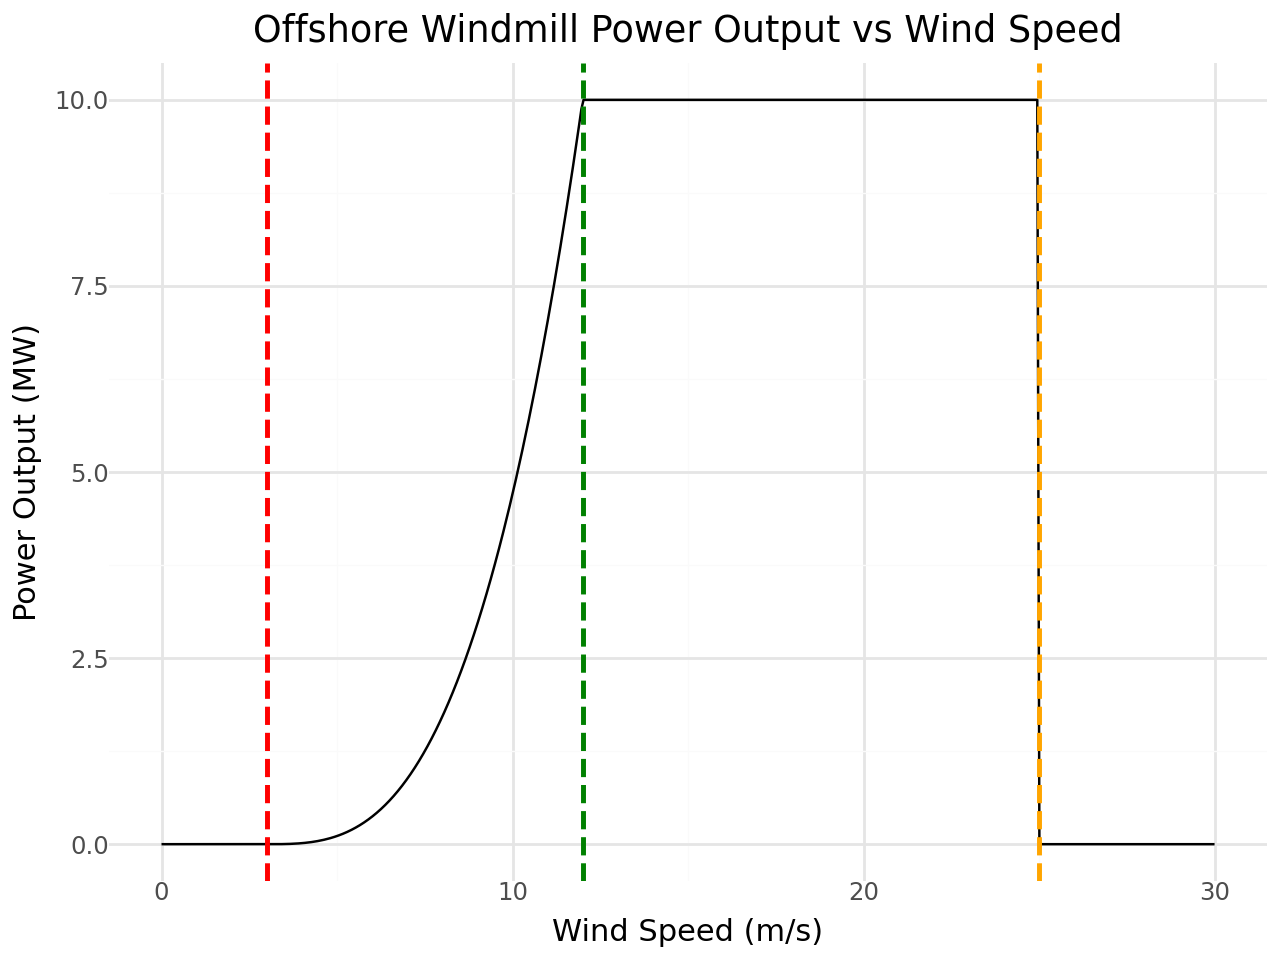

In [ ]:
def power(wind_speed, p_max=10, w_cut_in=3, w_rated=12, w_cut_out=25):
    """
    The power output of a wind turbine given a wind speed.

    Parameters:
    - wind_speed (float): The wind speed (in meters per second, m/s).
    - p_max (float, optional): The rated power of the wind turbine (in megawatts, MW). Default is 10 MW.
    - w_cut_in (float, optional): The cut-in wind speed (in meters per second, m/s). Default is 3 m/s.
    - w_rated (float, optional): The rated wind speed (in meters per second, m/s). Default is 12 m/s.
    - w_cut_out (float, optional): The cut-out wind speed (in meters per second, m/s). Default is 25 m/s.

    Returns:
    - float: The estimated power output (in megawatts, MW) based on the given wind speed.
    """
    if wind_speed < w_cut_in:
        return 0
    elif w_cut_in <= wind_speed <= w_rated:
        return p_max * ((wind_speed - w_cut_in) / (w_rated - w_cut_in)) ** 3
    elif w_rated < wind_speed <= w_cut_out:
        return p_max
    else:
        return 0

# Create a range of wind speeds for plotting
wind_speeds = np.linspace(0, 30, 500)

# Calculate the corresponding power outputs for the offshore windmill
power_outputs_offshore = [power(ws) for ws in wind_speeds]

# Create a DataFrame for plotnine
df = pd.DataFrame({
    'wind_speed': wind_speeds,
    'power_output': power_outputs_offshore
})

# Generate the plot using plotnine
w_cut_in_offshore = 3
w_rated_offshore = 12
w_cut_out_offshore = 25
p_max_offshore = 10
plot = (ggplot(df, aes(x='wind_speed', y='power_output'))
        + geom_line()
        + geom_vline(xintercept=w_cut_in_offshore, color='red', linetype='dashed', size=1, show_legend=True)
        + geom_vline(xintercept=w_rated_offshore, color='green', linetype='dashed', size=1, show_legend=True)
        + geom_vline(xintercept=w_cut_out_offshore, color='orange', linetype='dashed', size=1, show_legend=True)
        + labs(title='Offshore Windmill Power Output vs Wind Speed',
               x='Wind Speed (m/s)',
               y='Power Output (MW)')
        + theme_minimal()
        + scale_x_continuous(limits=(0, 30))
        + scale_y_continuous(limits=(0, p_max_offshore))
)
plot.show()

The power curve of a wind turbine describes how its power output varies with wind speed. Here's how it's created:

   * Cut-in Wind Speed: The minimum wind speed at which the turbine starts generating power.
   * Rated Wind Speed: The wind speed at which the turbine generates its maximum rated power.
   * Cut-out Wind Speed: The wind speed at which the turbine stops generating power for safety reasons (shut down).
   * Rated Power: The maximum power the turbine can produce when operating at the rated wind speed.

The calculation is as follows:

   * Below Cut-in Speed: If the wind speed is below the cut-in speed, the turbine produces no power (0 kW).
   * Between Cut-in and Rated Speed: As the wind speed increases, the turbine's power output increases non-linearly. This relationship is often modeled using a cubic function to simulate real-world turbine behavior.
   * At Rated Speed: When the wind speed reaches the rated speed, the turbine produces its maximum power and stays at this constant value for higher wind speeds.
   * Above Cut-out Speed: If the wind speed exceeds the cut-out speed, the turbine shuts down to prevent damage and produces no power.

Note that if the period we consider is one hour, the energy produced is equal to the power times one, i.e. MW equals MWh.



In [ ]:
from scipy.optimize import root_scalar

def energy(w, time_period_length = 1, p_max=10, w_cut_in=3, w_rated=12, w_cut_out=25):
    """
    The energy output of a wind turbine over one hour given a wind speed (MWh).

    Args:
    - w (float): The wind speed (in meters per second, m/s).
    - time_period_length (float, optional): The length of the time period (in hours). Default is 1 hour.

    returns:
    - (float) The energy produced.
    """
    return power(w, p_max, w_cut_in, w_rated, w_cut_out) * time_period_length

def energy_inverse(energy_target, time_period_length = 1, p_max=10, w_cut_in=3, w_rated=12, w_cut_out=25):
    """
    Find the wind speed that produces a given amount of energy, assuming wind is between w_cut_in and w_rated.

    Args:
        energy_target (float): The amount of energy to produce.

    Returns:
        float: The wind speed that produces the specified amount of energy.
    """
    if energy_target < 0 or energy_target > p_max:
        return None
    # if energy_target <= w_cut_in or energy_target >= w_cut_out:
    #     return 0
    # if energy_target >= w_rated:
    #     return p_max
    # Define a function representing the equation energy(w) - target_energy = 0
    def find_wind_speed(w):
        return energy(w, time_period_length, p_max, w_cut_in, w_rated, w_cut_out) - energy_target

    # Use fsolve to find the root (the wind speed)
    # Provide an initial guess for the wind speed (e.g., 10 m/s)

    sol = root_scalar(find_wind_speed, bracket=[w_cut_in, w_rated], method='brentq')
    return sol.root if sol.converged else None

    # initial_guess = 5
    # wind_speed_at_target_energy = fsolve(find_wind_speed, initial_guess)
    # if wind_speed_at_target_energy[0] < w_cut_in:
    #     return w_cut_in
    # if wind_speed_at_target_energy[0] > w_rated:
    #     return w_rated
    # return wind_speed_at_target_energy[0]

# Testing and verify the result
target = 8 # MWh
wind = energy_inverse(target)
display(Markdown(f"""
The wind speed required to produce {target} MWh of energy is approximately: {wind:.2f} m/s.\n
Energy produced at {wind:.2f} m/s: {energy(wind):.2f} MWh
"""))


The wind speed required to produce 8 MWh of energy is approximately: 11.35 m/s.

Energy produced at 11.35 m/s: 8.00 MWh


## Functions G and W

The functions for the endogeneous variables, are based on historical data and estimated using forecasting models.

### Price function $G(p)$

The model is fitted using an AR(1) model and can be loaded using:

In [ ]:
# Google Drive direct download URL (using the 'uc?id=' format)
url = 'https://drive.google.com/uc?id=1cGhte06iiWZnaRLPyj5D8ZzWX7gqPsIR'

# Output filename for the downloaded file
output_filename = 'prices_ar1.pkl.gz'

# Download the file from Google Drive
gdown.download(url, output_filename, quiet=True)

# Load the model from the downloaded file
with gzip.open(output_filename, "rb") as f:
    model_price = joblib.load(f)

display(Markdown(f"Model loaded successfully from {output_filename}"))

Model loaded successfully from prices_ar1.pkl.gz

We can now predict the price given hour, day and month:

In [ ]:
# Example
price = 100
phi = model_price.params.iloc[1]      # lag coefficient
intercept = model_price.params.iloc[0]    # intercept
price_next = intercept + phi * price
display(Markdown(f"""
Latest price: {price:.2f} EUR.\n
Predicted (mean) next hour price: {price_next:.2f} EUR
"""))


Latest price: 100.00 EUR.

Predicted (mean) next hour price: 98.21 EUR


 Moreover, the probability that the price falls within a given interval given current price is within an interval:

In [ ]:
import numpy as np
from scipy.stats import norm
from scipy.integrate import quad

def get_price_pr_inv(model, a, b, c, d):
    """
    Compute the conditional probability that P_{t+1} ∈ [a, b] given P_t ∈ [c, d]
    for a stationary AR(1) process with intercept.

    AR(1) Model:
        P_{t+1} = alpha + phi * P_t + epsilon_t
        where epsilon_t ~ N(0, sigma^2)

    Stationarity:
        The AR(1) process is considered stationary if the autoregressive coefficient satisfies:
            |phi| < 1

        Under stationarity:
            - The mean of W_t is constant over time: E[W_t] = mu = alpha / (1 - phi)
            - The variance of W_t is constant: Var(W_t) = sigma^2 / (1 - phi^2)
            - The process fluctuates around a stable long-term mean rather than trending or diverging

    Parameters:
        phi (float): AR(1) coefficient (must satisfy |phi| < 1 for stationarity)
        alpha (float): Intercept term in the AR(1) model
        sigma (float): Standard deviation of the noise term epsilon_t
        a (float): Lower bound of target interval for W_{t+1}
        b (float): Upper bound of target interval for W_{t+1}
        c (float): Lower bound of conditioning interval for W_t
        d (float): Upper bound of conditioning interval for W_t

    Returns:
        float: Conditional probability P(a ≤ W_{t+1} ≤ b | c ≤ W_t ≤ d)
    """
    phi = model.params.iloc[1]      # lag coefficient
    alpha = model.params.iloc[0]    # intercept
    sigma = model.resid.std()   # residual standard deviation

    # Long-run mean and stationary variance
    mu = alpha / (1 - phi)
    sigma_w = sigma / np.sqrt(1 - phi**2)

    def marginal_pdf_w(w):
        """PDF of stationary W_t ~ N(mu, sigma_w^2)."""
        return norm.pdf(w, loc=mu, scale=sigma_w)

    def integrand(w):
        """Integrand: conditional probability * marginal density."""
        mean_t1 = alpha + phi * w
        p = norm.cdf(b, loc=mean_t1, scale=sigma) - norm.cdf(a, loc=mean_t1, scale=sigma)
        return p * marginal_pdf_w(w)

    # Marginal probability P(c ≤ W_t ≤ d)
    p_wt_interval = norm.cdf(d, loc=mu, scale=sigma_w) - norm.cdf(c, loc=mu, scale=sigma_w)

    # Numerical integration over W_t in [c, d]
    integral_result, _ = quad(integrand, c, d)

    return integral_result / p_wt_interval

display(Markdown(f"""
Prob. of P_t+1 ∈ [0, 8] given P_t ∈ [3, 4]:
{get_price_pr_inv(model_price, 0, 8, 3, 4):.4f}
"""))


Prob. of P_t+1 ∈ [0, 8] given P_t ∈ [3, 4]:
0.1567


### Wind function $W(x)$

The model is fitted using AR(1) on log(wind speed) (since cannot be negative) and can be loaded using:

In [ ]:
# Google Drive direct download URL (using the 'uc?id=' format)
url = 'https://drive.google.com/uc?id=1TJ1ACzev40QbeUlXBbDicYU3kEyiH1nB'

# Output filename for the downloaded file
output_filename = 'wind_log_ar1.pkl.gz'

# Download the file from Google Drive
gdown.download(url, output_filename, quiet=True)

# Load the model from the downloaded file
with gzip.open(output_filename, "rb") as f:
    model_wind = joblib.load(f)

print(f"Model loaded successfully from {output_filename}")

Model loaded successfully from wind_log_ar1.pkl.gz


We can now predict the price given hour, day and month:

In [ ]:
# Example input: current price and time features
# Replace with actual values
wind = 0.03
log_wind = np.log(wind)
phi = model_wind.params['wind.L1'] # Access params from wind_result
intercept = model_wind.params['const'] # Access params from wind_result
log_wind_next = intercept + phi * log_wind
wind_next = np.exp(log_wind_next)

display(Markdown(f"""
Latest wind speed: {wind:.2f} m/s.\n
Predicted (mean) next hour wind speed: {wind_next:.2f} m/s
"""))


Latest wind speed: 0.03 m/s.

Predicted (mean) next hour wind speed: 0.97 m/s


 Moreover, the probability that the price falls within a given interval given current price is within an interval can be found:

In [ ]:
import numpy as np
from scipy.stats import norm, lognorm
from scipy.integrate import quad


def get_wind_pr_inv(model, a, b, c, d):
    """
    Compute the conditional probability:
        P(a ≤ W_{t+1} ≤ b | c ≤ W_t ≤ d)
    under a log-normal AR(1) model with intercept:
        log(W_{t+1}) = alpha + phi * log(W_t) + epsilon_t,
        where epsilon_t ~ N(0, sigma^2)

    This transformation ensures W_t > 0 and W_{t+1} > 0.

    Parameters:
        model: Fitted AutoRegResults object (log-AR(1) model)
        a (float): Lower bound of target interval for W_{t+1} (must be > 0)
        b (float): Upper bound of target interval for W_{t+1} (must be > a)
        c (float): Lower bound of conditioning interval for W_t (must be > 0)
        d (float): Upper bound of conditioning interval for W_t

    Returns:
        float: Conditional probability P(a ≤ W_{t+1} ≤ b | c ≤ W_t ≤ d)
    """
    # if a <= 0 or b <= 0 or c <= 0 or d <= 0:
    #     raise ValueError("All bounds must be strictly positive for log-normal model.")
    eps = 0.0001
    if a == 0: a = eps
    if b == 0: b = eps
    if c == 0: c = eps
    if d == 0: d = eps
    if a > b or c > d:
        raise ValueError("Invalid interval bounds.")

    # Extract model parameters
    phi = model.params.iloc[1]      # lag coefficient
    alpha = model.params.iloc[0]    # intercept
    sigma = model.resid.std()   # residual standard deviation

    # PDF of W_t under stationary distribution (assumed log-normal)
    # Approximate log(W_t) ~ N(mu, sigma_w^2) where mu = alpha / (1 - phi)
    mu_log = alpha / (1 - phi)
    sigma_log = sigma / np.sqrt(1 - phi**2)

    def marginal_pdf_w(w):
        """PDF of W_t under stationary log-normal assumption."""
        return lognorm.pdf(w, s=sigma_log, scale=np.exp(mu_log))

    def conditional_prob(w):
        """P(a ≤ W_{t+1} ≤ b | W_t = w) × f(W_t)"""
        if w <= 0:
            return 0.0
        mu = alpha + phi * np.log(w)
        p = lognorm.cdf(b, s=sigma, scale=np.exp(mu)) - lognorm.cdf(a, s=sigma, scale=np.exp(mu))
        return p * marginal_pdf_w(w)

    # Normalize over W_t ∈ [c, d]
    norm_const, _ = quad(marginal_pdf_w, c, d)
    integral_val, _ = quad(conditional_prob, c, d)

    return integral_val / norm_const

display(Markdown(f"""
Prob. of W_t+1 ∈ [0, 8] given W_t ∈ [3, 4]:
{get_wind_pr_inv(model_wind, 0, 8, 3, 4):.4f}
"""))


Prob. of W_t+1 ∈ [0, 8] given W_t ∈ [3, 4]:
0.5344


# Implementation

To solve the problem we need the following steps:

1) Discretizing the state and actions space
2) A function that find all states
3) A function that find all actions given a state
4) A reward function
5) A transition probability function
6) Build the MDP using the above

We will go through these steps one at a time.



## Discretizing the MDP

To solve the MDP we need to discreatize the states and actions. This can be done by assuming that:

- The battery only can be charged/discharged in units of $\delta$, e.g. $\delta = 0.25$ MWh. That is, $a^b_t \in \{-b^{\max}, \ldots, -\delta, 0, \delta, ..., b^{\max} \}$

- Hence the battery level is $s^l_t \in \{ 0, \delta, 2\delta, ..., b^{\max} \}$.

- The same units are used for the wind energy production $a^w_t \in \{ 0, \delta, 2\delta, ..., p^{\max} \}$.

- As a result, the commitment levels are $s^c_t \in \{ -b^\max, \ldots, -\delta, 0, \delta, \ldots, b^{\max} + p^{\max}\}$ since we can alt most buy energy for an empty battery and we can at most sell max wind production plus a full battery. The same intervals are used for $a^c_t$.

- The wind speed is split into intervals $s^w_t \in \{ I^w_1, I^w_2, \ldots, I^w_n \}$ of length $\gamma^w$ such that
    - $I^w_1 = [0, w^\text{cut_in}]$, i.e. from no wind to the cut-in wind speed.
    - The speed from $w^\text{cut_in}$ to $w^\text{rated}$ is split into lenghts of $\gamma$. That is $$I^w_j = ]a, b], \gamma = b-a.$$
    - A speed from $w^\text{rated}$ to $w^\text{cut_out}$ generates the same power, i.e $$I^w_{n-1} = ]w^\text{rated}, w^\text{cut_out}].$$
    - Finally over cut out speed no power is generated, i.e. $$I^w_n = ]w^{\text{cutout}}, \infty[.$$

- The price is split into intervals so $s^p_t \in \{ I^p_1, I^p_2, \ldots, I^p_n \}$ of length $\gamma^p$ such that $I^p_j = ]b, c]$ and $\gamma^p = c-b$. Special cases are $I^p_1 = (-\infty, a]$ (price below $a$) and $I^p_n = [d, \infty)$ (price above $d$).

Note $\delta$ must satisfy that $b^{\max}/\delta$ and $p^{\max}/\delta$ are integer. Moreover, when calculating $E(x)$, its value must be rounded down so contained in the set defined for $a^w_t$.

Instead of storing intervals, we may represent e.g. $I^w_i = ]a,b]$ as a number $c = (b-a)/2$ (the middle). Given $c$ we can always find $a = c - (b-a)/2$ and $b = c + (b-a)/2$.

Let us try to implement some functions for discreatization:

In [ ]:
def generate_discrete_set(min_val, max_val, step):
  """
  Generates a set of discrete values from min_val to max_val with step size.

  Args:
    min_val (float): The minimum value in the set.
    max_val (float): The maximum value in the set.
    step (float): The step size between consecutive values.

  Returns:
    set: A set of discrete values {min_val,…,−𝛿,0,𝛿,...,max_val}.
  """
  # Ensure step is a divisor of min_val
  if not np.isclose(min_val % step, 0):
      raise ValueError("min_val argument must be divisible by step.")
  if not np.isclose(max_val % step, 0):
      raise ValueError("max_val argument must be divisible by step.")

  return np.arange(min_val, max_val + step, step)


def generate_intervals(min_val, max_val, length, add_inf = False, add_neg_inf = False):
    """
    Splits a given interval into n evenly spaced subintervals of type ]a,b] and returns midpoints and their corresponding bounds.

    Args:
        min_val (float): The minimum bound value of the first interval.
        max_val (float): The maximum bound value of the last interval.
        length (float): The interval length.
        add_inf (bool): Add infinity interval too (midpoint is calculated based on the last interval).
        add_neg_inf (bool): Add negative infinity interval too (midpoint is calculated based on the first interval).

    Returns:
        dict: A dictionary containing:
            - midpoints (list): Sorted list of midpoints in the intervals.
            - intervals_dict (dict): Mapping of midpoints to a dictionary containing 'ab' (bounds) and 'length'.
            - lower_inf (bool): Indicates if a negative infinity interval was added.
            - upper_inf (bool): Indicates if an infinity interval was added.
    """
    if not np.isclose((max_val - min_val) % length, 0):
        raise ValueError("(max_val - min_val) must be divisible by length.")

    bounds = np.arange(min_val, max_val + length, length)
    midpoints = np.arange(min_val + length/2, max_val + length/2, length)
    midpoints = midpoints.tolist()
    bounds = bounds.tolist()

    intervals_dict = {}
    for i in range(len(midpoints)):
        intervals_dict[midpoints[i]] = {'ab': [bounds[i], bounds[i+1]], 'length': length}

    if add_neg_inf:
        neg_inf_midpoint = bounds[0] - 1  # Calculate midpoint for the negative infinity interval
        intervals_dict[neg_inf_midpoint] = {'ab': [-np.inf, bounds[0]], 'length': np.inf}
        midpoints.insert(0, neg_inf_midpoint)

    if add_inf:
        inf_midpoint = bounds[-1] + 1  # Calculate midpoint for the infinity interval
        intervals_dict[inf_midpoint] = {'ab': [bounds[-1], np.inf], 'length': np.inf}
        midpoints.append(inf_midpoint)

    return {"midpoints": midpoints, 'intervals_dict': intervals_dict, "lower_inf": add_neg_inf, "upper_inf": add_inf}


def get_interval(point, intervals, as_string = False):
    """
    Return interval bounds given a point and interval.

    Args:
        midpoint (float): The midpoint of the interval.
        intervals (dict): A dictionary
        as_string (bool): If true return the interval as a string.
    """
    midpoints = intervals['midpoints']
    intervals_dict = intervals['intervals_dict']
    lower_inf = intervals['lower_inf']
    upper_inf = intervals['upper_inf']

    # Check negative infinity interval
    if lower_inf and point < intervals_dict[midpoints[0]]['ab'][1]:
        if as_string:
            return str(intervals_dict[midpoints[0]]['ab'])
        else:
            return intervals_dict[midpoints[0]]['ab']

    # Check positive infinity interval
    if upper_inf and point >= intervals_dict[midpoints[-1]]['ab'][0]:
        if as_string:
            return str(intervals_dict[midpoints[-1]]['ab'])
        else:
            return intervals_dict[midpoints[-1]]['ab']

    # Check regular intervals
    for midpoint in midpoints:
        lower_bound, upper_bound = intervals_dict[midpoint]['ab']
        if lower_bound <= point < upper_bound:
            if as_string:
                return str(intervals_dict[midpoint]['ab'])
            else:
                return intervals_dict[midpoint]['ab']

    return None # Point is not in any defined interval


def get_midpoint(point, intervals, interior = False):
    """
    Return interval midpoint given a point and interval.

    Args:
        midpoint (float): The midpoint of the interval.
        intervals (dict): A dictionary
        interior (bool): If true only return the midpoint if the point is in the interior of an interval.
    """
    midpoints = intervals['midpoints']
    intervals_dict = intervals['intervals_dict']
    lower_inf = intervals['lower_inf']
    upper_inf = intervals['upper_inf']

    # Check negative infinity interval
    if lower_inf and point < intervals_dict[midpoints[0]]['ab'][1]:
        return midpoints[0]

    # Check positive infinity interval
    if not interior:
        if upper_inf and point >= intervals_dict[midpoints[-1]]['ab'][0]:
             return midpoints[-1]
    else:
        if upper_inf and point > intervals_dict[midpoints[-1]]['ab'][0]:
             return midpoints[-1]

    # Check regular intervals
    if not interior:
        for midpoint in midpoints:
            lower_bound, upper_bound = intervals_dict[midpoint]['ab']
            if lower_bound <= point < upper_bound:
                return midpoint
    else:
        for midpoint in midpoints:
            lower_bound, upper_bound = intervals_dict[midpoint]['ab']
            if lower_bound < point < upper_bound:
                return midpoint

    return None # Point is not in any defined interval


def add_interval(a, b, intervals):
    """
    Add an interval to a list of intervals.
    This function assumes intervals sorted by midpoint.

    Args:
        a (float): The lower bound of the interval to add.
        b (float): The upper bound of the interval to add.
        intervals (dict): The existing dictionary of intervals.
    """
    if a >= b:
        raise ValueError("Lower bound must be smaller than upper bound.")
    if get_midpoint(a, intervals, interior = True) is not None or get_midpoint(b, intervals, interior = True) is not None:
        raise ValueError("Upper or lower bound is already in an interval.")
    for midpoint in intervals['midpoints']:
        if a <= midpoint <= b:
            raise ValueError("Upper or lower bound is already in an interval.")
    if a == np.inf:
        raise ValueError("Lower bound cannot be infinity.")
    if b == -np.inf:
        raise ValueError("Upper bound cannot be -infinity.")

    if a == -np.inf:
        intervals['lower_inf'] = True
        midpoint = b - 1
        length = np.inf
    if b == np.inf:
        intervals['upper_inf'] = True
        midpoint = a + 1
        length = np.inf
    if not a == -np.inf and not b == np.inf:
        midpoint = a + (b - a) / 2
        length = b - a
    new_interval_info = {'ab': [a, b], 'length': length}

    # Find the correct insertion point for the midpoint
    insert_index = 0
    for i, existing_midpoint in enumerate(intervals['midpoints']):
        if midpoint > existing_midpoint:
            insert_index = i + 1
        else:
            break

    intervals['midpoints'].insert(insert_index, midpoint)
    intervals['intervals_dict'][midpoint] = new_interval_info


def remove_interval(point, intervals):
    """
    Remove an interval from the dictionary based on a point.

    Args:
        point (float): A point of the interval to remove.
        intervals (dict): The dictionary of intervals.

    Returns:
        bool: True if the interval was found and removed, False otherwise.
    """
    midpoint = get_midpoint(point, intervals)
    if not midpoint:
        return False

    if intervals['intervals_dict'][midpoint]['ab'][0] == -np.inf:
        intervals['lower_inf'] = False
    if intervals['intervals_dict'][midpoint]['ab'][1] == np.inf:
        intervals['upper_inf'] = False

    # Remove from midpoints list
    intervals['midpoints'].remove(midpoint)

    # Remove from intervals_dict
    del intervals['intervals_dict'][midpoint]

    return True


def join_intervals(a, b, intervals):
    """
    Join two intervals if they are adjacent.

    Args:
        a (float): The lower bound of the first interval.
        b (float): The upper bound of the second interval.
        intervals (dict): The dictionary of intervals.

    Returns:
        bool: True if the intervals were joined, False otherwise.
    """
    a = get_midpoint(a, intervals)
    b = get_midpoint(b, intervals)
    if not a or not b:
        raise ValueError("At least one of the points is not in an interval.")
    if a == b:
        raise ValueError("Points are in the same interval")
        return False
    if (a > b):
        a, b = b, a
    a_idx = intervals['midpoints'].index(a)
    b_idx = intervals['midpoints'].index(b)
    if (a_idx != b_idx - 1):
        return False
    a_ab = intervals['intervals_dict'][a]['ab']
    b_ab = intervals['intervals_dict'][b]['ab']
    new_ab = [a_ab[0], b_ab[1]]
    if a_ab[0] == -np.inf:
        new_midpoint = b_ab[1] - 1
        new_length = np.inf
    if b_ab[1] == np.inf:
        new_midpoint = a_ab[0] + 1
        new_length = np.inf
    if not a_ab[0] == -np.inf and not b_ab[1] == np.inf:
        new_length = b_ab[1] - a_ab[0]
        new_midpoint = a_ab[0] + new_length/2
    new_interval = {'ab': new_ab, 'length': new_length}
    intervals['intervals_dict'][new_midpoint] = new_interval
    del intervals['intervals_dict'][a]
    del intervals['intervals_dict'][b]
    intervals['midpoints'][a_idx] = new_midpoint
    intervals['midpoints'].remove(b)
    return True


def closest(lst, a):
    """
    Given a number finds the closest number in a list (if ties choose the smallest).

    Args:
        lst (list): The list of numbers to search within.
        a (float or int): The target number to find the closest value to.

    Returns:
        float or int: The number from the list that is closest to a.
    """
    idx = min(range(len(lst)), key=lambda i: abs(lst[i]-a))
    return lst[idx]


def get_left_or_right(sorted_list, a, return_left = True):
    """
    Given a sorted list and a number 'a', finds the left and right numbers
    in the list that 'a' is between.

    Args:
        sorted_list (list): A list of numbers sorted in ascending order.
        a (float or int): The number to find the bounds for.
        return_left (bool): If True, returns the left bound. If False, returns the right bound.

    Returns:
        list: If 'a' is equal to a number in the list, returns a.
              If 'a' is less than the smallest number, returns right.
              If 'a' is greater than the largest number, returns left.
              If 'a' is between two numbers in the list, returns left or right depending on `return_left`.
    """
    # Handle edge cases: a is less than the smallest or greater than the largest
    if a < sorted_list[0]:
        return sorted_list[0]
    if a > sorted_list[-1]:
        return sorted_list[-1]

    # Iterate through the sorted list to find the bounds
    for i in range(len(sorted_list) - 1):
        left = sorted_list[i]
        right = sorted_list[i+1]

        if left <= a <= right:
            # If a is exactly in the list or between two numbers
            if a == left or a == right:
                return a
            elif return_left:
                return left
            else:
                return right

    # This part should ideally not be reached if edge cases are handled and the list is sorted
    return None

Now let us see them in action:

In [ ]:
## Testing
dis = generate_discrete_set(0, 10, 2)
print("Point discreatization:", dis)
print("Find left point near 1.8:", get_left_or_right(dis, 1.8))
print("Find right point near 1.8:", get_left_or_right(dis, 1.8, False))

inv = generate_intervals(0, 2, 0.5, add_inf = True, add_neg_inf = False)
print("Intervals (w inf):")
pprint(inv)
print("Add interval:")
add_interval(-4, -3, inv)
add_interval(-np.inf, -4, inv)
pprint(inv)
print("Join intervals:")
get_midpoint(1.25, inv)
get_midpoint(1.75, inv)
join_intervals(1.25, 1.75, inv)
pprint(inv)
print("Find midpoint closest to -2.5:", closest(inv['midpoints'], -2.5))
print("Get intervals:")
print(get_interval(0, inv))
print(get_interval(0.5, inv))
print(get_interval(1.51, inv))
print(get_interval(2, inv))
print(get_interval(-3, inv))
print(get_interval(-4, inv))
print(get_interval(-7, inv))

Point discreatization: [ 0  2  4  6  8 10]
Find left point near 1.8: 0
Find right point near 1.8: 2
Intervals (w inf):
{'intervals_dict': {0.25: {'ab': [0.0, 0.5], 'length': 0.5},
                    0.75: {'ab': [0.5, 1.0], 'length': 0.5},
                    1.25: {'ab': [1.0, 1.5], 'length': 0.5},
                    1.75: {'ab': [1.5, 2.0], 'length': 0.5},
                    3.0: {'ab': [2.0, inf], 'length': inf}},
 'lower_inf': False,
 'midpoints': [0.25, 0.75, 1.25, 1.75, 3.0],
 'upper_inf': True}
Add interval:
{'intervals_dict': {-5: {'ab': [-inf, -4], 'length': inf},
                    -3.5: {'ab': [-4, -3], 'length': 1},
                    0.25: {'ab': [0.0, 0.5], 'length': 0.5},
                    0.75: {'ab': [0.5, 1.0], 'length': 0.5},
                    1.25: {'ab': [1.0, 1.5], 'length': 0.5},
                    1.75: {'ab': [1.5, 2.0], 'length': 0.5},
                    3.0: {'ab': [2.0, inf], 'length': inf}},
 'lower_inf': True,
 'midpoints': [-5, -3.5, 0.25, 0.75

We want to discretize as stated in

Assume the following parameter values are stored in a dictionary:

In [ ]:
settings = {
    ## Problem parameters
    'b_max': 10,  # battery capacity (MWh)
    'p_max': 10,  # max power output wind (MW)
    'c_max': 10 + 10,  # max commitment (MWh) # b_max + p_max
    'w_cut_in': 3,  # cut in wind speed (m/s)
    'w_rated': 12,  # rated wind speed (m/s)
    'w_cut_out': 25,  # cut out wind speed (m/s)
    'c_plus': 50,  # EUR/MWh
    'c_minus': 50, # EUR/MWh
}

### Q1

Using the implemented functions and the settings dict, create sets and intervals that discretise the state and action variables.

In [ ]:
#@title Solution

## Input parameters
step_mwh = 2  # step_mwh (float): Step size for energy resolution.
length_ms = 3  # length_ms (float): Length of intervals for wind speed.
length_p = 50  # length_p (float): Length of intervals for price.
min_p = -50  # min_p (float): Minimum price.
max_p = 250  # max_p (float): Maximum price.

## extract settings
b_max = settings['b_max']
p_max = settings['p_max']
c_max = settings['c_max']
w_cut_in = settings['w_cut_in']
w_rated = settings['w_rated']
w_cut_out = settings['w_cut_out']

## States variables
s_l_set = generate_discrete_set(0, b_max, step_mwh)
# your code

# s_w
s_w_inv = generate_intervals(w_cut_in, w_rated, length_ms)
add_interval(0, w_cut_in, s_w_inv)
# your code

# s_p
# your code

## Action variables
# your code

# View results
print("s_l:", s_l_set)
print("s_c:", s_c_set)
print("s_w:")
pprint(s_w_inv)
print("s_p:")
pprint(s_p_inv)
print("a_b:", a_b_set)
print("a_w:", a_w_set)
print("a_c:", a_c_set)

# Output:


{'midpoints': [4.5, 7.5, 10.5],
 'intervals_dict': {4.5: {'ab': [3, 6], 'length': 3},
  7.5: {'ab': [6, 9], 'length': 3},
  10.5: {'ab': [9, 12], 'length': 3}},
 'lower_inf': False,
 'upper_inf': False}

## States

Note that a state in the MDP is a combination of the state variables, and the state space consists of combinations of the state variables. In the `MDP` class states are stored as strings. As we will see later, it is useful to store a state as a string that can be converted to a directory. Let us define all states as strings that can easily be converted to a dict and see how it works:

In [ ]:
import ast

def state_variables_to_str(s_l, s_c, s_w, s_p):
    """
    String representaion of a state.
    """
    return "{'s_l': " + str(s_l) + ", 's_c': " + str(s_c) + ", 's_w': " + str(s_w) + ", 's_p': " + str(s_p) + "}"

def action_variables_to_str(a_b, a_w, a_c):
    """
    String representaion of an action.
    """
    return "{'a_b': " + str(a_b) + ", 'a_w': " + str(a_w) + ", 'a_c': " + str(a_c) + "}"

def str_to_dict(str):
    """
    Convert a string representation of a dictionary to a dictionary.

    Args:
        str (str): String representation of a dictionary.

    Returns:
        dict: Converted dictionary.
    """
    return ast.literal_eval(str)

# Testing
s = state_variables_to_str(1, 2, 3, 4)
print("State:", s)
s_dict = str_to_dict(s)
print("State as dict:", s_dict)
print("Access s_c:", s_dict['s_c'])

### Q2

Use the functions to store all states in a list. Hint: for state variables corresponding to intervals, use the midpoints. How many states are there?


In [ ]:
#@title Solution

# Find all combinations
state_labels = # your code [state_variables_to_str(...) for ...]
display(Markdown(f"There are {len(state_labels)} states."))

## Actions

Given a state, a set of actions is possible

### Q3

Create a function that takes a state (as a dict) and returns a list of possible actions (as dict).

In [ ]:
#@title Solution

def get_actions(s: dict, settings) -> list:
    """
    Get all possible actions for a given state.

    Args:
        s (dict): State containing 's_l', 's_c', 's_w', 's_p'.

    Returns:
        list: List of possible actions (as dict).
    """
    b_max = settings['b_max']
    # Determine a_b and a_w
    e_max = get_left_or_right(a_w_set, energy(s['s_w'])) # max energy we can sell/produce (e.g. if energy(s['s_w']) = 1.25 but a_w_set is [0,1,2,...] then can only sell 1)
    if s['s_c'] >= 0:
        if s['s_c'] >= e_max:
            # your code
        if s['s_c'] < e_max:
            # your code
    if s['s_c'] < 0:
        # your code

    actions = [action_variables_to_str(a_b, a_w, a_c) for a_c in a_c_set]
    # your code (actions to dict)
    return actions

# Test
s_lab = state_labels[300]
print("State:", s_lab)
print("Actions:")
pprint(get_actions(str_to_dict(s_lab), settings))

## Reward function

The expected reward can be calculated given a state and action.

### Q4

Create a function that calculates the reward given the state and action

In [ ]:
#@title Solution

def get_reward2(s_p, s_c, a_b, a_w, c_plus, c_minus):
    """
    Calculate the reward for given state-action values.

    Args:
        s_p (float): Price.
        s_c (float): Commitment.
        a_b (float): Energy transferred to the battery.
        a_w (float): Energy produced by the wind turbine.
        c_plus (float): Penalty cost of energy above zero.
        c_minus (float): Penalty cost of energy below zero.

    Returns:
        float: Reward value.

    Raises:
        ValueError: If the reward cannot be calculated.
    """
     # your code e =
    if s_p >= 0:
        # your code
    if s_p < 0:
        # your code
    raise ValueError("Reward can not be calculated.")

Note that in the above reward function, the price is fixed. Since we know that the price state variable defines an interval, we need to calculate the expected reward over the interval:

In [ ]:
import numpy as np
from scipy import integrate

def mean_value(f, a, b, *params):
    """
    Compute the mean value of a function f(x, *params) over interval [a,b].

    Parameters
    ----------
    f : callable
        Function f(x, *params) where x is the variable of integration.
    a, b : float
        Interval [a, b] over which to compute the mean.
    *params : extra arguments
        Constants passed to f.

    Returns
    -------
    float
        Mean value of f over [a, b].
    """
    I, _ = integrate.quad(f, a, b, args=params)  # definite integral
    return I / (b - a)


def get_mean_reward(s_p, s_c, a_b, a_w, c_plus, c_minus, s_p_inv, lower_limit = -60, upper_limit = 260):
    """
    Calculate the mean reward for given state-action values when s_p is within a given interval.

    Args:
        s_p (float): Price midpoint.
        s_c (float): Commitment.
        a_b (float): Energy transferred to the battery.
        a_w (float): Energy produced by the wind turbine.
        c_plus (float): Penalty cost of energy above zero.
        c_minus (float): Penalty cost of energy below zero.
        s_p_inv (dict): Price state intervals.
        lower_limit (float, optional): Lower limit used if the lower limit of the interval is -inf. Defaults to -60.
        upper_limit (float, optional): Upper limit used if the upper limit of the interval is inf. Defaults to 260.

    Returns:
        float: Mean reward
    """
    ab = s_p_inv['intervals_dict'][s_p]['ab']
    if np.isinf(ab[1]):
        return mean_value(get_reward2, ab[0], upper_limit, s_c, a_b, a_w, c_plus, c_minus)

    if np.isinf(ab[0]):
        return mean_value(get_reward2, lower_limit, ab[1], s_c, a_b, a_w, c_plus, c_minus)

    return mean_value(get_reward2, ab[0], ab[1], s_c, a_b, a_w, c_plus, c_minus)

# np.isinf(-np.inf)
# s_p_inv
# get_reward2(25, 10, 4, 2, 500, 500)
# get_mean_reward(25, 10, 4, 2, 500, 500, s_p_inv)
# get_reward2(101, 10, 4, 2, 500, 500)
# get_mean_reward(101, 10, 4, 2, 500, 500, s_p_inv)
# get_reward2(-51, 10, 4, 2, 500, 500)
# get_mean_reward(-51, 10, 4, 2, 500, 500, s_p_inv)
# join_intervals(-51, -25, s_p_inv)
# get_mean_reward(-1, 10, 4, 2, 500, 500, s_p_inv)

To verify the reward function, we want to plot it. First, we generate a data frame with the reward:

In [ ]:
def generate_rewards(c_plus = 500, c_minus = 500):
    s_c = s_c_set
    s_p = s_p_inv['midpoints']
    a_b = a_b_set
    a_w = a_w_set
    all_combinations = list(itertools.product(s_c, s_p, a_b, a_w))  # get all combinations of the variables
    df = pd.DataFrame(all_combinations, columns=['s_c', 's_p', 'a_b', 'a_w'])
    df = (df
        >> mutate(e = X.a_b + X.a_w)
        >> mutate(imbalance = abs(X.s_c - X.e))
        >> mutate(state = [state_variables_to_str(0, s_c, 0, s_p) for s_c, s_p in zip(df['s_c'], df['s_p'])])
        >> mutate(action = [action_variables_to_str(a_b, a_w, 0) for a_b, a_w in zip(df['a_b'], df['a_w'])])
    )
    df['reward'] = df.apply(lambda x: get_reward2(x['s_p'], x['s_c'], x['a_b'], x['a_w'], c_plus, c_minus), axis = 1)
    df['mean_reward'] = df.apply(lambda x: get_mean_reward(x['s_p'], x['s_c'], x['a_b'], x['a_w'], c_plus, c_minus, s_p_inv), axis = 1)
    df = df >> mask(~((X.s_c > 0) & (X.e < 0))) >> mask(~((X.s_c < 0) & (X.e > 0)))  # remove rows which are not possible
    return df

df = generate_rewards(500, 0)
display(df)

### Q5

Plot the reward using the data frame by:

- Having `s_p` and `reward` on the x-axis and y-axis, respectively.
- Use lines and points to plot the reward.
- Use different colors for `s_c`.
- Make a subplot (facet) for each `imbalance`.
- Try different values of `[c_plus, c_minus]`, e.g. [50, 25], [25, 50] and [0, 0].

Hint: You may use `theme(figure_size=(16,10))` to make the plot big. Make `s_c` categorical (discrete) using `pd.Categorical(df['s_c'])`.

Verify that the rewards satisfy   

- The reward increases for increasing prices if commitment is positive for price, either below or above zero.
- The reward decreases for increasing prices if commitment is negative, for price, either below or above zero.
- For a fixed positive price, the reward increases with the commitment.
- For a fixed negative price, the reward decreases with the commitment.
- For increasing imbalance, the reward decreases.



In [ ]:
#@title Solution

def plot_reward(c_plus, c_minus):
    dat = generate_rewards(c_plus, c_minus)
    dat['s_c'] = pd.Categorical(dat['s_c'])
    pt = (
        # ggplot(dat, aes(...))
        # your code
    )
    pt.show()

plot_reward(50, 25)
plot_reward(25, 50)
plot_reward(0, 0)
plot_reward(500, 500)

## Transition probability funciton

Given the discretization we need to be able to calculate probabilities:

\begin{align}
    p(s^w_{t+1} | s^w_t) &= p(s^w_{t+1} \in I_{t+1} | s^w_t \in I_t) \\
    p(s^p_{t+1} | s^p_t) &= p(s^p_{t+1} \in I_{t+1} | s^p_t \in I_t) \\
\end{align}

Let us implement these functions:

In [ ]:
def get_trans_pr_w(s_w, s_w_next, s_w_inv):
    """
    Calculate the transition probability for wind states.

    Args:
        s_w (float): Current wind speed.
        s_w_next (float): Next wind speed.
        s_w_inv (dict): wind state intervals.

    Returns:
        float: Transition probability between the current and next wind state interval.
    """
    a, b = get_interval(s_w_next, s_w_inv)
    c, d = get_interval(s_w, s_w_inv)
    pr_w = get_wind_pr_inv(model_wind, a, b, c, d)
    return pr_w

def get_trans_pr_p(s_p, s_p_next, s_p_inv):
    """
    Calculate the transition probability for price states.

    Args:
        s_p (float): Current price.
        s_p_next (float): Next price.

    Returns:
        float: Transition probability between the current and next price state.
    """
    a, b = get_interval(s_p_next, s_p_inv)
    c, d = get_interval(s_p, s_p_inv)
    pr_p = get_price_pr_inv(model_price, a, b, c, d)
    return pr_p

# Test
print("Pr w:", get_trans_pr_w(0, 0.5, s_w_inv))
print("Pr p:", get_trans_pr_p(0, 1.25, s_p_inv))

Given the above functions we may store all values in two matrices:

In [ ]:
# Save all combinations in a matrix pr_w_mat[s_w, s_w_next]
pr_w_mat = np.zeros((len(s_w_inv['midpoints']), len(s_w_inv['midpoints'])))
for r in range(pr_w_mat.shape[0]):
    for c in range(pr_w_mat.shape[1]):
        pr_w_mat[r, c] = get_trans_pr_w(
            s_w_inv['midpoints'][r],
            s_w_inv['midpoints'][c],
            s_w_inv
        )
if any(abs(pr_w_mat.sum(axis = 1) - 1) > 0.000001):
    raise ValueError("Error don't sum to one!")
# normalize small diffs
pr_w_mat = pr_w_mat / pr_w_mat.sum(axis = 1, keepdims = True)

# Save all combinations in a matrix pr_p_mat[s_p, s_p_next]
pr_p_mat = np.zeros((len(s_p_inv['midpoints']), len(s_p_inv['midpoints'])))
for r in range(pr_p_mat.shape[0]):
    for c in range(pr_p_mat.shape[1]):
        pr_p_mat[r, c] = get_trans_pr_p(
            s_p_inv['midpoints'][r],
            s_p_inv['midpoints'][c],
            s_p_inv
        )
if any(abs(pr_p_mat.sum(axis = 1) - 1) > 0.000001):
    raise ValueError("Error don't sum to one!")
# normalize small diffs
pr_p_mat = pr_p_mat / pr_p_mat.sum(axis = 1, keepdims = True)

### Q6

These can be used to calculate the transition probabilities. Finish the function below

In [ ]:
#@title Solution

def get_trans_pr(s, a_c, a_b, pr_w_mat, pr_p_mat, s_w_inv, s_p_inv):
    """
    Compute the transition probabilities for a given state and actions. Assume
    the states and actions are discretised values.

    Args:
        s (dict): Current state, containing 's_l', 's_c', 's_w', 's_p'.
        a_c (float): Commitment.
        a_b (float): Energy transferred to the battery.
        pr_w_mat (np.ndarray): Transition probability matrix for wind states.
        pr_p_mat (np.ndarray): Transition probability matrix for price states.
        s_w_inv (dict): wind state intervals.
        s_p_inv (dict): price state intervals.

    Returns:
        dict: Dictionary of transition probabilities to the next states.
    """
    res = {}
    # s_l_next = ...
    # s_c_next = ...
    s_w_idx = s_w_inv['midpoints'].index(s['s_w'])
    s_p_idx = s_p_inv['midpoints'].index(s['s_p'])

    for s_w_next_idx, s_w_next in enumerate(s_w_inv['midpoints']):
        for s_p_next_idx, s_p_next in enumerate(s_p_inv['midpoints']):
            # s_next = ...
            # pr_w = ...
            # pr_p = ...
            # p = ...
            # if p > 0:
            #     res[s_next] = ...
    return res

# Test
s = state_labels[4]
s = str_to_dict(s)
print("State:", s)
pr = get_trans_pr(s, 10, 4, pr_w_mat, pr_p_mat, s_w_inv, s_p_inv)
print("Pr:", pr)
print("Sum:",sum(pr.values()))

## Building the MDP

We are now ready to build the MDP.

### Q7

Create a function that, given the settings, builds the MDP using the MDP class and returns it.

In [ ]:
#@title Solution

def build_mdp(settings, s_l_set, s_c_set, s_w_inv, s_p_inv, a_b_set, a_w_set, a_c_set, pr_w_mat, pr_p_mat):
    mdp = MDP()  # Create MDP

    # Add states
    # state_labels = ...
    mdp.add_state_space(state_labels)

    # Add actions
    for s_label in mdp.get_state_keys():
        s = str_to_dict(s_label)  # Convert state string to dict
        for a in get_actions(s, settings):  # Add possible actions
            action_label = str(a)
            # your code
            # mdp.add_action(...)

    print("MDP info:", mdp.get_mdp_info())
    return mdp

# mdp = build_mdp(...)
mdp.check(delta=0.0001)  # check if diff below 0.0001 (assume ok)
mdp.normalize()  # normalize pr so sum to one

## Solving the MDP and reviewing results

### Q8

Find the optimal policy given a discount rate of 0.5.



In [ ]:
#@title Solution

# <your code>

To verify the model, we need to transform the policy into a dataframe:

In [ ]:
policy = mdp.get_policy(add_state_values = True)

# Apply the parsing functions to create new columns with state variables
df_result = policy
# df_result.info()
df_result = df_result.join(df_result['state'].apply(str_to_dict).apply(pd.Series))
df_result = df_result.join(df_result['action'].apply(str_to_dict).apply(pd.Series))
df_result = (
    df_result
        >> mutate(e = X.a_b + X.a_w)
        >> mutate(imbalance = (X.e != X.s_c),
                  E = [energy(s_w) for s_w in df_result['s_w']],
                  reward = [mdp.get_reward(s, a) for s, a in zip(df_result['state'], df_result['action'])]
        )
)

# Add interval index and labels
df_result = df_result >> mutate(s_w_idx = [np.argmax(df_result['s_w'].unique() == v) for v in df_result['s_w']],
                                s_w_str = [get_interval(s_w, s_w_inv, as_string=True) for s_w in df_result['s_w']])
df_result = df_result >> mutate(s_p_idx = [np.argmax(df_result['s_p'].unique() == v) for v in df_result['s_p']],
                                s_p_str = [get_interval(s_p, s_p_inv, as_string=True) for s_p in df_result['s_p']])

# Get steady state pr and join
pr = mdp.get_steady_state_pr(tol=0.00001).drop(columns = 'pr')
pr.set_index(['state', 'action'], inplace=True)
df_result.set_index(['state', 'action'], inplace=True)
df_result = df_result.join(pr)

display(df_result)

Note that the we calculate the steady state probabilities. The steady state distribution is a probability distribution over states that remains unchanged as time goes to infinity.  

If $\pi$ is the optimal policy and $P^\pi$ is its transition matrix, the steady-state distribution $\mu$ satisfies:
$$
\mu P^\pi = \mu, \quad \sum_{i} \mu_i = 1.
$$
It tells you what fraction of time (in the long run) the system spends in each state under policy $\pi$.

### Q9

Verify the model (is the model implemented correctly?) by checking

1. If commit to the grid, then receiving energy should not be possible.
2. If commit from the grid, then sending energy should not be possible.
3. If commit from the grid, then discharging the battery should not be possible
4. Using a negative amount of wind should not be possible.
5. How many times is there an imbalance if commit from the grid? Is it reasonable?
6. How many times is there an imbalance if commit to the grid? Is it reasonable?


In [ ]:
#@title Solution

## Verification – “Did we build the model right?”
print("1:", len(df_result >> mask(X.e < 0, X.s_c > 0)), end = ", ")
# print("2:", ..., end = ", ")
# your code

### Q10

Validate the model (are the model's results reasonable?). Check the results by filtering the data frame.

1. Do we choose to commit to the grid in the next period when prices (midpoints) are negative?
2. Do we choose not to commit to the grid in the next period when prices (midpoints) are positive?
3. How many different values of `a_c` is used?
4. What actions are taken given the price and wind? Make a plot with
   - `s_w_idx` and `s_p_idx` on the x-axis and y-axis, respectively.
   - Consider low, mid and high values of `s_l` and low, mid and high values of `s_c`.
   - Use `a_c` as label and color aesthetics.
   - Use labels as geom.
   - Make a subplot (facet) with rows `s_l` and cols `s_c`.
   - Plot only states with a steady state probability larger than zero.

   Make `s_c` categorical (discrete) using `pd.Categorical(df['s_c'])`.

   - Is commitment increasing with prices?
   - Do we have imbalances in the states we visit, given the optimal policy?
   - Why are commitments the same no matter the value of `s_w` if `s_c` is negative?

5. Make the same plot as above, but add reward as a label instead of `a_c`.
   - Are the rewards as expected?


In [ ]:
#@title Solution

## Validation – “Did we build the right model?”
# your code

Let us put it all together

### Q11

Join all the calculations into a function `build_and_solve_mdp`, that takes arguments: `settings, s_l_set, s_c_set, s_w_inv, s_p_inv, a_b_set, a_w_set, a_c_set, gamma`. The function build and solve the MDP. Next, the results are plotted.  


In [ ]:
#@title Solution

def build_and_solve_mdp(settings, s_l_set, s_c_set, s_w_inv, s_p_inv, a_b_set, a_w_set, a_c_set, gamma):
    ## Calc trans pr matrices for s_w and s_p
    # Save all combinations in a matrix pr_w_mat[s_w, s_w_next]
    # your code

    # Save all combinations in a matrix pr_p_mat[s_p, s_p_next]
    # your code

    ## Build the MDP
    # your code

    ## Optimize
    # your code

    ## Get results/policy dataframe
    # your code

    ## Plot results
    dat = (
        df_result
            # >> mask((X.s_l == 0) | (X.s_l == 5) | (X.s_l == 10)) >> mask((X.s_c == -10) | (X.s_c == -2) | (X.s_c == 0) | (X.s_c == 2))   # mask(~X.imbalance)
            >> mask(X.steady_pr > 0)
    )
    dat['a_c'] = pd.Categorical(dat['a_c'])  # Convert 'a_c' to a categorical variable for discrete scaling
    # your code

    return mdp, df_result

Test it using the same settings as before:

In [ ]:
settings = {
    ## Problem parameters
    'b_max': 10,  # battery capacity (MWh)
    'p_max': 10,  # max power output wind (MW)
    'c_max': 10 + 10,  # max commitment (MWh) # b_max + p_max
    'w_cut_in': 3,  # cut in wind speed (m/s)
    'w_rated': 12,  # rated wind speed (m/s)
    'w_cut_out': 25,  # cut out wind speed (m/s)
    'c_plus': 50,  # EUR/MWh
    'c_minus': 50, # EUR/MWh
}

b_max = settings['b_max']
p_max = settings['p_max']
c_max = settings['c_max']
w_cut_in = settings['w_cut_in']
w_rated = settings['w_rated']
w_cut_out = settings['w_cut_out']
step_mwh = 2
length_ms = 3
length_p = 50
min_p = -50
max_p = 250

## States variables
s_l_set = generate_discrete_set(0, b_max, step_mwh)
s_c_set = generate_discrete_set(-b_max, c_max, step_mwh)

# s_w
s_w_inv = generate_intervals(w_cut_in, w_rated, length_ms)
add_interval(0, w_cut_in, s_w_inv)
add_interval(w_rated, w_cut_out, s_w_inv)
add_interval(w_cut_out, np.inf, s_w_inv)

# s_p
s_p_inv = generate_intervals(min_p, max_p - 150, length_p, add_inf = True, add_neg_inf = True)

## Action variables
a_b_set = generate_discrete_set(-b_max, b_max, step_mwh)
a_w_set = generate_discrete_set(0, p_max, step_mwh)
a_c_set = generate_discrete_set(-b_max, c_max, step_mwh)

mdp, df_result = build_and_solve_mdp(settings, s_l_set, s_c_set, s_w_inv, s_p_inv, a_b_set, a_w_set, a_c_set, 0.9)

Note that it seems that the same action is taken for prices above/below zero. Hence, we may focus on small intervals here only. Moreover, not all possible commitments are used in states where the steady state probability is non-zero. This is due to the intervals chosen for wind speed not corresponding to all possible commitment values.

Let us try to define different intervals for the price and wind:

In [ ]:
# Make s_p_inv smaller
print("Current prices:")
pprint(s_p_inv)
s_p_inv = generate_intervals(-20, 5, 5, add_inf = True, add_neg_inf = True)
print("New prices:")
pprint(s_p_inv)

# Make new s_w_inv
print("Commitment values:", a_w_set)  # commitment values
print("Commitment values used:", dat['a_w'].unique())  # a_c values used
e_prod = [energy(w) for w in s_w_inv['midpoints']] # possible energy production given wind intervals
print("Possible energy production given wind intervals:", e_prod)
print("What we can sell:", [get_left_or_right(a_w_set, e) for e in e_prod])  # what we can sell
# pprint(s_w_inv)  # current wind speeds used
val = [round(energy_inverse(e), 1) for e in a_w_set]  # wind speeds corresponding to a_w_set
print("Wind speeds corresponding to a_w_set:", val)
# Modify s_w_inv
s_w_inv = generate_intervals(0, w_cut_in, w_cut_in)
for i, v in enumerate(val):
    if i > 0:
        add_interval(val[i-1], v, s_w_inv)
# pprint(s_w_inv)
add_interval(w_rated, w_cut_out, s_w_inv)
add_interval(w_cut_out, np.inf, s_w_inv)
print("New intervals:")
pprint(s_w_inv)

### Q12

Solve the new model and comment on the results.

In [ ]:
# your code